## <b>AI-based equilibrium reconstrucion for ITER-like device<b>

This notebok shows how a simple neural network (multi-layer perceptron) can be trained to perform equilibrium reconstruction (i.e. reconstruct the poloidal flux in the poliodal plane) starting from magnetic measures. An ITER-like geometry is used for this purpose (this approach uses a a set of synthetic flux loops sensors that is not consistent with actual sensors foreseen in real ITER).

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"   

# Helper libraries
import numpy as np
from numpy import matlib as mb
import matplotlib.pyplot as plt
import scipy.io

# !pip install seaborn
import seaborn as sns
sns.set_style("darkgrid")

# import random

# import matplotlib.lines as mlines

from datetime import datetime
from packaging import version

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# !pip install tensorflow
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import KFold, train_test_split

import scipy.interpolate as interp
import matplotlib.lines as mlines

Num GPUs Available:  0
TensorFlow version:  2.9.1


In [2]:
folder = 'C:\\Users\\bonotto\\Dropbox\\PhD\\RESEARCH_ACTIVITY\\ML\\Equilibrium_ML\\Physics_Informed_AI_plasma_equilibrium\\data\\'
### load probes data and fluxes
filename = folder + 'Database_probes_psi_Jphi_ITER_Tensorflow.mat'    
mat = scipy.io.loadmat(filename)
    
X_data_load = (mat['meas_Psi_fake'])
y_data_load = (mat['Psi']) 
Jphi_data = mat['Jphi']
Ipla = mat['Ipla']

meas_Psi_fake_pts = mat['meas_Psi_fake_pts']
meas_B_pts = mat['meas_B_pts']

y_data_load/=(2*np.pi)
X_data_load/=(2*np.pi)

RR = mat['RR']
ZZ = mat['ZZ']
coll_pts = mat['coll_pts']
rr = coll_pts[:,0]
zz = coll_pts[:,1]

rz_points = np.column_stack((rr,zz))


### load mesh
filename = folder + 'INPUT_FRIDA_geo_IET.mat'
mat = scipy.io.loadmat(filename,struct_as_record=True)
meshData_loc = (mat['meshData_loc'])
meshData_loc_n = meshData_loc['n'][0,0]
meshData_loc_t = meshData_loc['t'][0,0]

In [3]:
'''Routine for plotting the results'''
def fun_contourf_sol(z,rz_points):
    
    rr = rz_points[:,0]
    zz = rz_points[:,1]
    interpolator = interp.CloughTocher2DInterpolator(np.column_stack((rr,zz)), z.flatten().T)
    xv, yv = np.meshgrid(np.linspace(min(RR.reshape(-1,1)),max(RR.reshape(-1,1)),150),
                         np.linspace(min(ZZ.reshape(-1,1)),max(ZZ.reshape(-1,1)),150))    
    psi_grid = interpolator(xv, yv)

    plt.figure()
    plt.contourf(xv, yv, psi_grid, 30)
    plt.axis('equal')
    plt.show()
    plt.colorbar()
    return


def fun_contour_sol(z,rz_points):
    
    rr = rz_points[:,0]
    zz = rz_points[:,1]
    interpolator = interp.CloughTocher2DInterpolator(np.column_stack((rr,zz)), z.flatten().T)
    xv, yv = np.meshgrid(np.linspace(min(RR.reshape(-1,1)),max(RR.reshape(-1,1)),150),
                         np.linspace(min(ZZ.reshape(-1,1)),max(ZZ.reshape(-1,1)),150))    
    psi_grid = interpolator(xv, yv)

    plt.figure()
    plt.contour(xv, yv, psi_grid, 30)
    plt.axis('equal')
    plt.show()
    plt.colorbar()
    return


def fun_contour_compare_sol(z_ref,z,rz_points):
    
    rr = rz_points[:,0]
    zz = rz_points[:,1]
    xv, yv = np.meshgrid(np.linspace(min(RR.reshape(-1,1)),max(RR.reshape(-1,1)),150),
                         np.linspace(min(ZZ.reshape(-1,1)),max(ZZ.reshape(-1,1)),150))    

    interpolator = interp.CloughTocher2DInterpolator(np.column_stack((rr,zz)), z_ref.flatten().T)
    psi_grid_ref = interpolator(xv, yv)

    interpolator = interp.CloughTocher2DInterpolator(np.column_stack((rr,zz)), z.flatten().T)
    psi_grid = interpolator(xv, yv)

    l1 = mlines.Line2D([], [], label='network')
    l2 = mlines.Line2D([], [], color='black', label='reference')
    
    plt.figure()
    plt.contour(xv, yv, psi_grid, 10)
    plt.colorbar()
    plt.contour(xv, yv, psi_grid_ref, 10, colors = 'black', linestyles = 'dashed')
    plt.legend(handles=[l1, l2])
    plt.axis('equal')
    plt.show()
    return


def fun_prepare_NN_input(meas,rz_points):
    n_sample = meas.shape[0]
    XX = np.repeat(meas.T,rz_points.shape[0],1).T
    XX = np.column_stack((XX,np.tile(rz_points, [n_sample,1])))
    return XX


In [4]:
### Prepare data
X_data = X_data_load
X_data = np.column_stack((X_data_load,Ipla))
y_data = y_data_load



### selec a portion of all the available equilibria
ind_subsample = np.random.randint(0,X_data.shape[0],50000)
ind_probes = np.arange(0,X_data.shape[1])

X = X_data[np.ix_(ind_subsample, ind_probes)]
y = y_data[ind_subsample,:]
Jphi = Jphi_data[ind_subsample,:]



### Standardize input data
X = StandardScaler().fit_transform(X)
np.mean(X[:,0])



### Train-test split
X_id = np.column_stack([np.arange(0,X.shape[0]),X])
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(X_id, 
                                                                        y, 
                                                                        test_size=0.05, 
                                                                        random_state=42)

id_train = data_X_train[:,0]
id_test = data_X_test[:,0]

data_X_train = data_X_train[:,1:]
data_X_test = data_X_test[:,1:]

data_Source_train = Jphi[np.int_(id_train),:]
data_Source_test = Jphi[np.int_(id_test),:]



### Reshape and include collocation points
def fun_prepare_NN_input_new(X,y,Source,coll_pts):
    y = y.reshape(-1,1)
    Source = Source.reshape(-1,1)
    
    coll_pts_reshape = np.tile(coll_pts, [X.shape[0],1])
    X = np.repeat(X.T,coll_pts.shape[0],1).T
    
    # stack X|collocation points
    X = np.column_stack((X,coll_pts_reshape))
    return X,y,Source


X_train, y_train, Source_train = fun_prepare_NN_input_new(data_X_train, data_y_train, data_Source_train, coll_pts)
X_test, y_test, Source_test = fun_prepare_NN_input_new(data_X_test, data_y_test, data_Source_test, coll_pts)


### Print some info
print('N sample train ->', X_train.shape[0])
print('N sample test  ->', X_test.shape[0])

n_output = y_train.shape[1]
n_input = X_train.shape[1]

print('X.shape =', X.shape)
print('Y.shape =', y.shape)


# Convert input to tensor
X_train = tf.convert_to_tensor(X_train, dtype=('float32'))
y_train = tf.convert_to_tensor(y_train, dtype=('float32'))
X_test = tf.convert_to_tensor(X_test, dtype=('float32'))
y_test = tf.convert_to_tensor(y_test, dtype=('float32'))
Source_train = tf.convert_to_tensor(Source_train, dtype=('float32'))
Source_test = tf.convert_to_tensor(Source_test, dtype=('float32'))

N sample train -> 15152500
N sample test  -> 797500
X.shape = (50000, 97)
Y.shape = (50000, 319)


In [5]:
def init_model(num_hidden_layers=6, num_neurons_per_layer=60):
    ''' Initialize a feedforward neural network '''
    model = tf.keras.Sequential()

    ''' Input is two-dimensional (time + one spatial dimension) '''
    model.add(tf.keras.Input(n_input,))

    ''' Append hidden layers '''
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('swish'),
            kernel_initializer='he_normal'))

    ''' Output is linear, one-dimensional '''
    model.add(tf.keras.layers.Dense(n_output))
    
    return model


### Init and compile the model
model = init_model(num_hidden_layers=6, 
                   num_neurons_per_layer=60)
model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = 'mae',
              run_eagerly=False)

Choose bach size as perfect divider of the training dataset.

In [6]:
def get_divisors(n):
    div = []
    for i in range(1, int(n / 2) + 1):
        if n % i == 0:
            div.append(i)
    return np.asarray(div).reshape(-1,1)

batch_size = 5000
epochs = 40

divisors = get_divisors(X_train.shape[0])
tmp = np.abs(batch_size - divisors)
index = np.where(tmp == tmp.min())
batch_size = int(divisors[np.where(tmp == tmp.min())])

print('batch_size =', batch_size)

batch_size = 5225


Train the model.

In [7]:
start = datetime.now()
history = model.fit(X_train, 
                    y_train,
                    epochs=40,
                    batch_size = batch_size,
                    verbose = 1)
print(datetime.now() - start)

Epoch 1/40
2900/2900 [==============================] - 50s 17ms/step - loss: 0.7896 - mae: 0.3735
Epoch 2/40
2900/2900 [==============================] - 50s 17ms/step - loss: 0.0507 - mae: 0.1554
Epoch 3/40
2900/2900 [==============================] - 48s 17ms/step - loss: 0.0353 - mae: 0.1283
Epoch 4/40
2900/2900 [==============================] - 47s 16ms/step - loss: 0.0292 - mae: 0.1159
Epoch 5/40
2900/2900 [==============================] - 47s 16ms/step - loss: 0.0255 - mae: 0.1077
Epoch 6/40
2900/2900 [==============================] - 47s 16ms/step - loss: 0.0228 - mae: 0.1017
Epoch 7/40
2900/2900 [==============================] - 51s 17ms/step - loss: 0.0206 - mae: 0.0960
Epoch 8/40
2900/2900 [==============================] - 52s 18ms/step - loss: 0.0191 - mae: 0.0924
Epoch 9/40
2900/2900 [==============================] - 47s 16ms/step - loss: 0.0177 - mae: 0.0888
Epoch 10/40
2900/2900 [==============================] - 47s 16ms/step - loss: 0.0167 - mae: 0.0858
Epoch 11/

Plot history and compute $R^2$ score

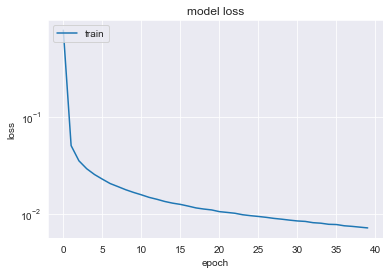

Rsquared_train = 99.98188120209322
Rsquared_test = 99.98171009334823


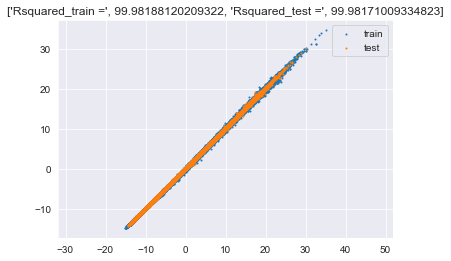

In [8]:
### summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Score
predictions_train = model(X_train).numpy()
predictions_test = model(X_test).numpy()         

Rsquared_train = r2_score(predictions_train, y_train)*100
Rsquared_test = r2_score(predictions_test, y_test)*100
print('Rsquared_train =', Rsquared_train)
print('Rsquared_test =', Rsquared_test)

factor_subsampling = 10
plt.figure()
plt.scatter(y_train[0:-1:factor_subsampling,0], predictions_train[0:-1:factor_subsampling,0], 1, label = 'train')
plt.scatter(y_test[0:-1:factor_subsampling,0], predictions_test[0:-1:factor_subsampling,0], 1, label = 'test')
plt.axis('equal')
plt.legend()
plt.title(['Rsquared_train =', Rsquared_train, 'Rsquared_test =', Rsquared_test])
plt.show()

Check reconstruction on **training** data.

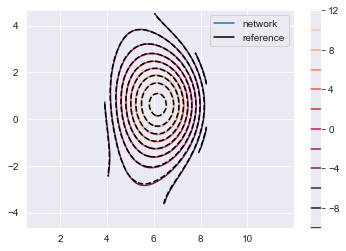

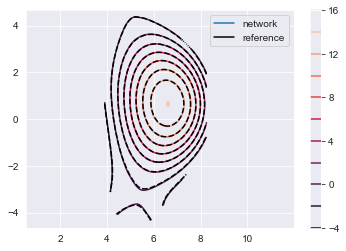

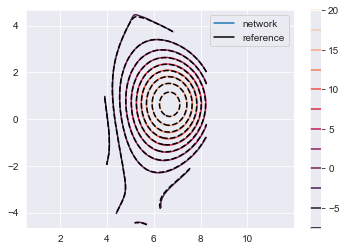

In [9]:
### Check on training data
for ii in range(0,3):
    ind_test_sample = np.random.randint(0,data_X_train.shape[0:1],1)
    
    XX, yy, _ = fun_prepare_NN_input_new(data_X_train[ind_test_sample,:], 
                                         data_y_train[ind_test_sample,:], 
                                         data_Source_train[ind_test_sample,:], 
                                         coll_pts)
    yy_NN = model(XX).numpy().reshape(-1,1)
    yy_ref = yy
    fun_contour_compare_sol(yy_ref,yy_NN,coll_pts)

Check reconstruction on **test** data.

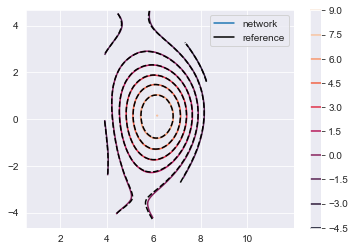

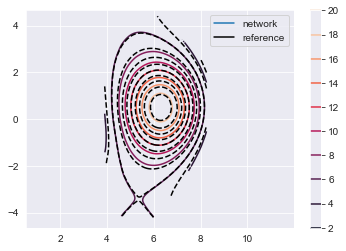

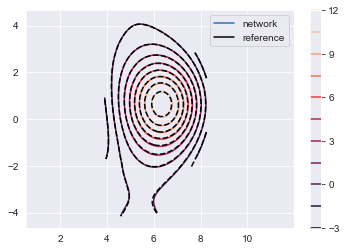

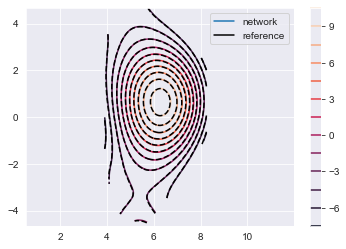

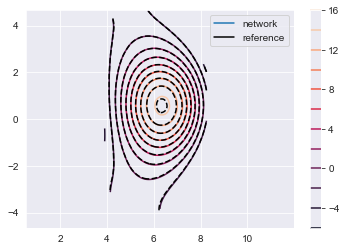

In [10]:
### Check on test data
for ii in range(0,5):
    ind_test_sample = np.random.randint(0,data_X_test.shape[0:1],1)
    
    XX, yy, _ = fun_prepare_NN_input_new(data_X_test[ind_test_sample,:], 
                                         data_y_test[ind_test_sample,:], 
                                         data_Source_test[ind_test_sample,:], 
                                         coll_pts)
    yy_NN = model(XX).numpy().reshape(-1,1)
    yy_ref = yy
    fun_contour_compare_sol(yy_ref,yy_NN,coll_pts)